In [ ]:
import pandas as pd
import numpy as np
import keras
import tensorflow

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls -l '/content/drive/My Drive/Colab Notebooks/datasets/img_final_mdx.zip'

-rw------- 1 root root 311857006 Apr 21 00:44 '/content/drive/My Drive/Colab Notebooks/datasets/img_final_mdx.zip'


In [ ]:
!unzip '/content/drive/My Drive/Colab Notebooks/datasets/img_final_mdx.zip'

In [ ]:
image_dir = 'img'

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

random_seed = 414

datagen = ImageDataGenerator(rescale = 1./255, validation_split=0.2)

train = datagen.flow_from_directory(image_dir,target_size = (640, 640), seed=random_seed,
                                                    batch_size = 1515, class_mode = 'binary', subset='training')
test_generator = datagen.flow_from_directory(image_dir, target_size=(640, 640), seed=random_seed,
                                              batch_size=40, class_mode='binary', subset='validation')


Found 1515 images belonging to 2 classes.
Found 377 images belonging to 2 classes.


In [ ]:
type(train)

tensorflow.python.keras.preprocessing.image.DirectoryIterator

In [ ]:
X_train, y_train = train.next()

In [ ]:
print(type(X_train), type(y_train))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


# train data _ split -> train_generator : valid_generator

In [ ]:
datagen_second = ImageDataGenerator(validation_split=0.2)

train_generator = datagen_second.flow(X_train, y_train , seed=random_seed, batch_size = 40, subset='training')
valid_generator = datagen_second.flow(X_train, y_train , seed=random_seed, batch_size = 40, subset='validation')

In [ ]:
print(len(train_generator))
print(len(valid_generator))

31
8


In [ ]:
# for pred, label in train_generator:
#   print(pred.shape)
#   print(label.shape)
#   print(label)
#   break

## fine tuning - block5_conv1

In [ ]:
from keras.applications import VGG16

conv_base = VGG16(weights = 'imagenet', include_top = False, input_shape = (640, 640, 3))

set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'block5_conv1':       
    set_trainable = True

  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

conv_base.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 640, 640, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 640, 640, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 640, 640, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 320, 320, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 320, 320, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 320, 320, 128)     147584    
______________________________________________________________

In [ ]:
from keras import models, layers, optimizers

model = models.Sequential()
model.add(conv_base)

model.add(layers.Flatten())
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation = 'sigmoid'))   

model.summary()


model.compile(loss = 'binary_crossentropy', 
              optimizer = optimizers.Adam(lr = 0.000005),
              metrics = ['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 20, 20, 512)       14714688  
_________________________________________________________________
flatten (Flatten)            (None, 204800)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               52429056  
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 67,145,025
Trainable params: 59,509,249
Non-trainable params: 7,635,776
____________________________________

In [ ]:
%%time

Hist = model.fit(train_generator, 
                 steps_per_epoch = 31, 
                 epochs = 50, 
                 validation_data = valid_generator,
                 validation_steps=8)

Epoch 1/50
31/31 [==============================] - 152s 3s/step - loss: 0.7918 - accuracy: 0.6066 - val_loss: 0.4783 - val_accuracy: 0.8119
Epoch 2/50
31/31 [==============================] - 62s 2s/step - loss: 0.2931 - accuracy: 0.8755 - val_loss: 0.4396 - val_accuracy: 0.8185
Epoch 3/50
31/31 [==============================] - 63s 2s/step - loss: 0.1611 - accuracy: 0.9445 - val_loss: 0.3894 - val_accuracy: 0.8482
Epoch 4/50
31/31 [==============================] - 64s 2s/step - loss: 0.1414 - accuracy: 0.9607 - val_loss: 0.3586 - val_accuracy: 0.8647
Epoch 5/50
31/31 [==============================] - 64s 2s/step - loss: 0.0977 - accuracy: 0.9793 - val_loss: 0.3270 - val_accuracy: 0.8713
Epoch 6/50
31/31 [==============================] - 64s 2s/step - loss: 0.0607 - accuracy: 0.9895 - val_loss: 0.3326 - val_accuracy: 0.8779
Epoch 7/50
31/31 [==============================] - 64s 2s/step - loss: 0.0423 - accuracy: 0.9983 - val_loss: 0.3463 - val_accuracy: 0.8614
Epoch 8/50
31/31 [=

9/9 [==============================] - 13s 1s/step - loss: 0.2221 - accuracy: 0.9194
Loss = 0.22208
Accuracy = 0.91944


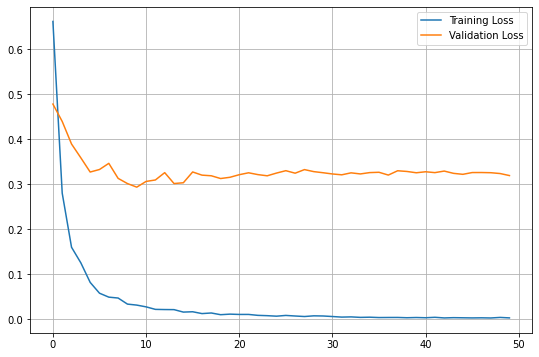

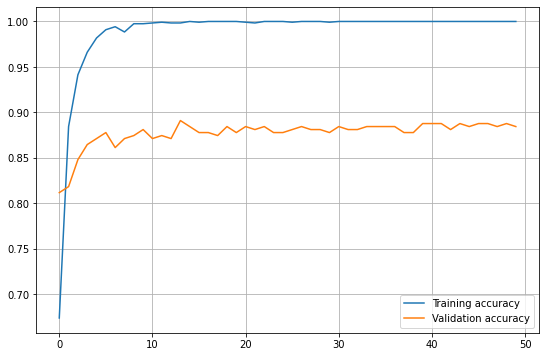

In [ ]:
import matplotlib.pyplot as plt


loss, accuracy = model.evaluate(test_generator, steps=9)
print('Loss = {:.5f}'.format(loss))
print('Accuracy = {:.5f}'.format(accuracy))




plt.figure(figsize = (9, 6))
plt.plot( Hist.history['loss'])
plt.plot(Hist.history['val_loss'])

plt.legend(['Training Loss', 'Validation Loss'])
plt.grid()
plt.show()


plt.figure(figsize = (9, 6))
plt.plot(Hist.history['accuracy'])
plt.plot( Hist.history['val_accuracy'])

plt.legend(['Training accuracy', 'Validation accuracy'])
plt.grid()
plt.show()

## Visualization

In [ ]:
import pathlib
from glob import glob

data_root = pathlib.Path(glob('/content/*/')[1])
print(data_root)
# label = ['0','1']

/content/img


In [ ]:
import random

all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]

# random.choice(all_image_paths)

all_image_paths

['/content/img/0/669.jpg',
 '/content/img/0/489.jpg',
 '/content/img/0/6.jpg',
 '/content/img/0/626.jpg',
 '/content/img/0/909.jpg',
 '/content/img/0/400.jpg',
 '/content/img/0/330.jpg',
 '/content/img/0/792.jpg',
 '/content/img/0/97.jpg',
 '/content/img/0/69.jpg',
 '/content/img/0/101.jpg',
 '/content/img/0/171.jpg',
 '/content/img/0/329.jpg',
 '/content/img/0/410.jpg',
 '/content/img/0/93.jpg',
 '/content/img/0/261.jpg',
 '/content/img/0/641.jpg',
 '/content/img/0/373.jpg',
 '/content/img/0/469.jpg',
 '/content/img/0/724.jpg',
 '/content/img/0/36.jpg',
 '/content/img/0/76.jpg',
 '/content/img/0/789.jpg',
 '/content/img/0/378.jpg',
 '/content/img/0/379.jpg',
 '/content/img/0/42.jpg',
 '/content/img/0/483.jpg',
 '/content/img/0/70.jpg',
 '/content/img/0/849.jpg',
 '/content/img/0/802.jpg',
 '/content/img/0/509.jpg',
 '/content/img/0/299.jpg',
 '/content/img/0/9.jpg',
 '/content/img/0/128.jpg',
 '/content/img/0/695.jpg',
 '/content/img/0/935.jpg',
 '/content/img/0/606.jpg',
 '/content/i

In [ ]:
import PIL.Image as Image
import matplotlib.pyplot as plt
import random
import numpy as np
import cv2

plt.figure(figsize=((16, 25)))


for n in range(15):
    #랜덤 이미지 경로 추출
    image_path = random.choice(all_image_paths)
    
    #이미지 크기 변경 
    img = cv2.imread(image_path)
    img = cv2.resize(img, (640,640))

    # 이미지 크기 정규화
    reg = img / 255.0  
    reg = np.expand_dims(reg, axis=0)

    # 이미지 분류
    logits = model.predict(reg)[0]


    #이미지 출력
    plt.subplot(5,3, n+1)
    plt.imshow(plt.imread(image_path))
    idx = image_path.split('/')[-2]
    plt.title('label: ' + str(idx))
    plt.xlabel(str(logits))
    #plt.xlabel(confusion_matrix(img, model.predict))
    # plt.xlabel(arr)

